# Testing the Matrix Recurrent - Memory Augmented Neural Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/

/content/drive


In [3]:
cd 'My Drive'/

/content/drive/My Drive


In [4]:
cd 'RNN CONTROLLER'

/content/drive/My Drive/RNN CONTROLLER


In [5]:
import MatrixNTM
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys

Setting the Random Seed

In [6]:
torch.manual_seed(31)

Bit Error per Sequence Performance measure 

In [7]:

def Bit_Seq_Error(output , target, batch_size, sequence_length):
    bit_output = output.detach().clone()
    bit_output[bit_output >= 0.5] = 1.0
    bit_output[bit_output != 1.0] = 0.0
    bit_error = torch.sum((torch.abs(target - bit_output)) )/(batch_size*sequence_length)
    return bit_error


# **COPY TASK**

Parameters for Training

In [ ]:
NUM_EPOCHS = 50000

BATCH_SIZE = 32
INPUT_DIMS  = [5,5]
HIDDEN_DIMS = [10,10]
OUTPUT_DIMS = [5,5]
NUM_SLOTS = 120
MEM_SLOT_DIMS = [10,10]
SR = 1 #Shift Range
EPS = 1e-10

LR = 1e-4

DEVICE = 'cuda:0' #'None' for CPU 

SAVE_PATH = 'SavedModels/RNNMatNTM_Copy1/Train5_20_9/'

Random Testing, delete all the cells till next section when not in use...

Setting The Matrix Copy Task Generator

In [ ]:
def MatrixCopyDataGen(batch_size = 32, item_size = [4,5], timesteps = 2, device = None):
    
    assert item_size[0] == item_size[1] - 1
    
    pre_content = torch.rand([batch_size, item_size[0]+1, item_size[1]*timesteps])
    
    pre_content[:,:-1,:][pre_content[:,:-1,:] > 0.5] = 1.0
    pre_content[:,-1,:] = 0.0
    pre_content[pre_content != 1] = 0.0
        
    limiter = torch.zeros([batch_size, item_size[0]+1, item_size[1]])
    limiter[:,-1,:] = 1.0
    #response_sheet = torch.zeros_like(pre_content)
    
    
    question = torch.cat([pre_content, limiter], dim = 2)
    
    return question.to(device), pre_content.to(device)


Loading Model

In [ ]:

MNTM = MatrixNTM.MatRNN_NTM(batch_size=BATCH_SIZE, input_dims=INPUT_DIMS, hidden_dims=HIDDEN_DIMS, output_dims=OUTPUT_DIMS, NumSlots=NUM_SLOTS, MemorySlot_dims=MEM_SLOT_DIMS, shift_range=SR, eps = EPS, device=DEVICE)
MNTM = MNTM.to(DEVICE)

Loading Optimizer and Loss Function

In [ ]:
loss_func = torch.nn.BCELoss()

optim = torch.optim.RMSprop(params = MNTM.parameters(), lr = LR, momentum = 0.9)



Gradient Clipping for Training Stability

In [ ]:
#Backward Hooks for gradient clipping
for p in MNTM.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -10, 10)) 
print("All gradients will be clipped between {} ".format((-10,10)))


All gradients will be clipped between (-10, 10) 


$\verb|Save()|$ function (Make sure the directory exists)

In [ ]:

def Save(optim_dict_too = True):
	torch.save(MNTM, SAVE_PATH + 'MNTM.pth')
	if optim_dict_too:
		torch.save(optim.state_dict(), SAVE_PATH + 'optim_state_dict.pth')


## The Training Loop for **COPY TASK**


In [ ]:
a = [0.0 for _ in range(NUM_EPOCHS)]
b = [0.0 for _ in range(NUM_EPOCHS)]
c = [0.0 for _ in range(int(NUM_EPOCHS/100))]
d = [0.0 for _ in range(int(NUM_EPOCHS/100))]

TrainLosses = torch.tensor(a,dtype=torch.float64)
TrainBitErrors = torch.tensor(b, dtype=torch.float64)

ValidationLosses = torch.tensor(a,dtype=torch.float64)
ValidationBitErrors = torch.tensor(b, dtype=torch.float64)


torch.cuda.set_device(0)

try:

    for i in range(NUM_EPOCHS):

      if ((i+1)%500) == 0:
        clear_output(wait=False)

      num_t =  int( torch.randint(low=1, high=21, size=[], device=DEVICE) )

      inp, out = MatrixCopyDataGen(BATCH_SIZE,[INPUT_DIMS[0]-1, INPUT_DIMS[1]],num_t,DEVICE)
      
      response_sheet = torch.zeros_like(out)

      print("Epoch: ",i)
      print("--->Sequence Length: ",int(num_t))

      MNTM.HiddenReset()

      MNTM.zero_grad()

      #Feeding the sequence
      for t in range(1,num_t+2):
        _ = MNTM(inp[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])

      #Taking Output from controller now, for backprop
      output = []

      for t in range(1,num_t+1):
        MNTM_out = MNTM(response_sheet[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
        output.append(MNTM_out)


      res = torch.cat(output, dim=2)

      loss = loss_func(res, out)
      bse = Bit_Seq_Error(res, out, BATCH_SIZE, num_t)

      print("----->Loss: {}".format(loss))
      print("----->Sequence Bit Error: {}".format(bse))

      print("--||--||--||--||--||--||--||--||--")

      loss.backward()

      optim.step()

      TrainLosses[i] = loss.detach().data
      TrainBitErrors[i] = bse

      torch.cuda.empty_cache()

      #Regular Check
      if (i+1)%100 == 0:


        # num_t = torch.randint(low=70,high=101,size=[])
        num_t = 60

        inp, out = MatrixCopyDataGen(BATCH_SIZE,[INPUT_DIMS[0]-1, INPUT_DIMS[1]],num_t,DEVICE)
        
        response_sheet = torch.zeros_like(out)

        print("Epoch: ",i)
        print("--->Sequence Length: ",int(num_t))

        MNTM.HiddenReset()

        MNTM.zero_grad()

        #Feeding the sequence
        for t in range(1,num_t+2):
            _ = MNTM(inp[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])

        #Taking Output from controller now, for backprop
        output = []

        for t in range(1,num_t+1):
            MNTM_out = MNTM(response_sheet[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
            output.append(MNTM_out)

        res = torch.cat(output, dim=2)

        loss = loss_func(res, out)
        bse = Bit_Seq_Error(res, out, BATCH_SIZE, num_t)

        print("\n---------->Validation Loss on Sequence Length {} : {}".format(num_t,loss))
        print("---------->Validation BSE on Sequence Length {} : {}".format(num_t, bse))
        print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-")

        ValidationLosses[int((i+1)/100)] = loss.detach().data
        ValidationBitErrors[int((i+1)/100)] = bse


      if (i+1)%1000 == 0:
        #pass
        Save()
        torch.save({'TrainLoss' : TrainLosses, 'TrainBSE' : TrainBitErrors, 'ValidationLoss' : ValidationLosses, 'ValidationBSE' : ValidationBitErrors, 'TillEpoch' : i}, SAVE_PATH + 'LossTrace.pth')

except ValueError as e:
  #print(e)
  print("Value error... Get up: ", sys.exc_info()[0])
  Save(False)
  torch.save({'TrainLoss' : TrainLosses, 'TrainBSE' : TrainBitErrors, 'ValidationLoss' : ValidationLosses, 'ValidationBSE' : ValidationBitErrors, 'TillEpoch' : i},SAVE_PATH + 'LossTrace.pth')
  print("Model Save Successfull!")

Epoch:  16499
--->Sequence Length:  3
----->Loss: 0.06535008549690247
----->Sequence Bit Error: 0.1041666716337204
--||--||--||--||--||--||--||--||--
Epoch:  16499
--->Sequence Length:  60

---------->Validation Loss on Sequence Length 60 : 0.5157151222229004
---------->Validation BSE on Sequence Length 60 : 8.494791984558105
-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-
Epoch:  16500
--->Sequence Length:  19
----->Loss: 0.40068408846855164
----->Sequence Bit Error: 5.8601975440979
--||--||--||--||--||--||--||--||--
Epoch:  16501
--->Sequence Length:  2
----->Loss: 0.0029671501833945513
----->Sequence Bit Error: 0.0
--||--||--||--||--||--||--||--||--
Epoch:  16502
--->Sequence Length:  4
----->Loss: 0.07196049392223358
----->Sequence Bit Error: 0.2890625
--||--||--||--||--||--||--||--||--
Epoch:  16503
--->Sequence Length:  10
----->Loss: 0.2498597651720047
----->Sequence Bit Error: 2.9937500953674316
--||--||--||--||--||--||--||--||--
Epoch:  16504
--->Sequence Length:  4
----->Loss: 0.0802418291

# **ASSOCIATIVE RECALL**

Parameters for Training

In [10]:
NUM_EPOCHS = 50000

ITEM_SIZE = 2 #Size of the group which you would like to call "1 Item".

BATCH_SIZE = 32
INPUT_DIMS  = [5,5]
HIDDEN_DIMS = [20,20]
OUTPUT_DIMS = [5,5]
NUM_SLOTS = 120
MEM_SLOT_DIMS = [20,20]
SR = 1 #Shift Range
EPS = 1e-10

LR = 1e-4

DEVICE = 'cuda:0' #'None' for CPU 

LOAD_SAVE = True

SAVE_PATH = 'SavedModels/RNNMatNTM_AssRec1/Train1_19_9/'

Associative Recall Data Generator

In [9]:
def OneBatchSequence(seq_size = [4,5], item_size = 2, num_items = 15, query_num = 14):
    
    assert num_items > query_num
    
    limiter = torch.zeros([seq_size[0]+1, seq_size[1]])
    limiter[-1,0] = 1.0
    limiter[-1,-1] = 1.0
    
    
    cat_list = []
    for i in range(num_items):
        
        cat_list.append(limiter)
        
        content = torch.rand([seq_size[0]+1, seq_size[1] * item_size])
        content[:-1,:][content[:-1,:] > 0.5] = 1.0
        content[-1,:] = 0.0
        content[content != 1] = 0.0
        cat_list.append(content)
        
    
    delimeter = torch.zeros([seq_size[0]+1, seq_size[1]])
    delimeter[-1,1:-1] = 1.0
    cat_list.append(delimeter)
    
    
    start = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*2)
    stop = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*2) + (seq_size[1]*2) 
    
    sequence = torch.cat(cat_list, dim = 1)
    
    query = sequence[:,start:stop]
    expected_result = sequence[:,start+3*seq_size[1] : stop+3*seq_size[1]]

    
    finalsequence = torch.cat([sequence, query], dim = 1)
            
    
    return finalsequence, expected_result




def GenRandBatchSeq(batch_size=32, seq_size = [4,5], item_size = 2, num_items = 15, device = None):
    
    seq_list = []
    res_list = []
    
    
    
    for i in range(batch_size):
        query_num = torch.randint(low=1, high=num_items, size=[])
        seq, res = OneBatchSequence(seq_size=seq_size, item_size=item_size, num_items=num_items, query_num=query_num)
        seq_list.append(seq.unsqueeze(0))
        res_list.append(res.unsqueeze(0))
    
    seq_tensor = torch.cat(seq_list, dim=0)
    res_tensor = torch.cat(res_list, dim=0)
    
    return seq_tensor.to(device), res_tensor.to(device)


Loading Model

In [14]:
if LOAD_SAVE == True:
  MNTM = torch.load(SAVE_PATH + 'MNTM.pth')
  optim_state_dict = torch.load(SAVE_PATH + 'optim_state_dict.pth')
  LossTrace = torch.load(SAVE_PATH + 'LossTrace.pth')
  print("Previously Trained till : {}".format(LossTrace['TillEpoch']))
  if LossTrace['TillEpoch'] == NUM_EPOCHS-1:
    print("Training was completed previously!! {} ".format(LossTrace['TillEpoch']))

else:
  MNTM = MatrixNTM.MatRNN_NTM(batch_size=BATCH_SIZE, input_dims=INPUT_DIMS, hidden_dims=HIDDEN_DIMS, output_dims=OUTPUT_DIMS, NumSlots=NUM_SLOTS, MemorySlot_dims=MEM_SLOT_DIMS, shift_range=SR, eps = EPS, device=DEVICE)
  MNTM = MNTM.to(DEVICE)



Previously Trained till : 33999


$\verb|Save()|$ function (Make sure the directory exists)

In [15]:

def Save(optim_dict_too = True):
	torch.save(MNTM, SAVE_PATH + 'MNTM.pth')
	if optim_dict_too:
		torch.save(optim.state_dict(), SAVE_PATH + 'optim_state_dict.pth')


Gradient Clipping

In [16]:
#Backward Hooks for gradient clipping
for p in MNTM.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -20, 20)) 
print("All gradients will be clipped between {} ".format((-20,20)))


All gradients will be clipped between (-20, 20) 


Loading Optimizer

In [25]:
loss_func = torch.nn.BCELoss()

if LOAD_SAVE == True:
  optim = torch.optim.RMSprop(params = MNTM.parameters(), lr = LR, momentum = 0.9)
  optim.load_state_dict(optim_state_dict)

else:
  optim = torch.optim.RMSprop(params = MNTM.parameters(), lr = LR, momentum = 0.9)

Training Loop for **Associative Recall**

In [27]:

min_loss = 0.7

if LOAD_SAVE == False:
  a = [0.0 for _ in range(NUM_EPOCHS)]
  b = [0.0 for _ in range(NUM_EPOCHS)]
  c = [0.0 for _ in range(int(NUM_EPOCHS/100))]
  d = [0.0 for _ in range(int(NUM_EPOCHS/100))]

  TrainLosses = torch.tensor(a,dtype=torch.float64)
  TrainBitErrors = torch.tensor(b, dtype=torch.float64)

  ValidationLosses = torch.tensor(c,dtype=torch.float64)
  ValidationBitErrors = torch.tensor(d, dtype=torch.float64)

else: 
  TrainLosses = LossTrace['TrainLoss']
  TrainBitErrors = LossTrace['TrainBSE']

  ValidationLosses = LossTrace['ValidationLoss']
  ValidationBitErrors = LossTrace['ValidationBSE']


if LOAD_SAVE:
  start = LossTrace['TillEpoch']
else:
  start = -1


#try:
  
for i in range(start+1, NUM_EPOCHS):

  if ((i+1)%500) == 0:
    clear_output(wait=False)

  num_items = torch.randint(low=2, high=16, size=[],device=DEVICE)

  inp, out = GenRandBatchSeq(batch_size=BATCH_SIZE, seq_size=[INPUT_DIMS[0]-1,INPUT_DIMS[1]], item_size=ITEM_SIZE, num_items=num_items, device=DEVICE)
  #inp, out = MatrixCopyDataGen(32,[4,5],num_t)

  response_sheet = torch.zeros_like(out)

  print("Epoch: ",i)

  print("--->Number of Items: ",int(num_items))

  MNTM.HiddenReset()

  MNTM.zero_grad()



  #Feeding the sequence
  #Input sequence is of length inp.shape[2]/5 

  num_sequences = int(inp.shape[2]/INPUT_DIMS[1])


  for t in range(1,num_sequences+1):
      _ = MNTM(inp[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
                                  #5 is the seq_size[1]                    

  #Taking Output from controller now, for backprop
  output = []
                  # 2 is the item_size
  for t in range(1,ITEM_SIZE+1):
    MNTM_out = MNTM(response_sheet[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
    output.append(MNTM_out)


  res = torch.cat(output, dim=2)

  loss = loss_func(res, out)

  bse = Bit_Seq_Error(res, out, BATCH_SIZE, ITEM_SIZE)

  print("----->Loss: {}".format(loss))
  print("----->Bit Sequence Error : {}".format(bse))
  print("--||--||--||--||--||--||--||--||--")

  loss.backward()

  optim.step()

  # if LOAD_SAVE:
  #   LossTrace['TrainLoss'][i] = loss.detach().data
  #   LossTrace['TrainBSE'][i] = bse

  #else:
  TrainLosses[i] = loss.detach().data
  TrainBitErrors[i] = bse

  torch.cuda.empty_cache()

  #Regular Check
  if (i+1)%100 == 0:

    # num_t = torch.randint(low=70,high=101,size=[])
    num_items = 30

    inp, out = GenRandBatchSeq(batch_size=BATCH_SIZE, seq_size=[INPUT_DIMS[0]-1,INPUT_DIMS[1]], item_size=ITEM_SIZE, num_items=num_items,  device=DEVICE)
    #inp, out = MatrixCopyDataGen(32,[4,5],num_t)

    response_sheet = torch.zeros_like(out)

    print("--->Number of Items: ",int(num_items))

    MNTM.HiddenReset()

    MNTM.zero_grad()

    #Feeding the sequence
    #Input sequence is of length inp.shape[2]/5 

    num_sequences = int(inp.shape[2]/INPUT_DIMS[1])
                                #5 is the seq_size[1] 

    for t in range(1,num_sequences+1):
      _ = MNTM(inp[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
                                    #5 is the seq_size[1]                    

    #Taking Output from controller now, for backprop
    output = []
                    # 2 is the item_size
    for t in range(1,ITEM_SIZE+1):
      MNTM_out = MNTM(response_sheet[:,:,(t-1)*INPUT_DIMS[1]:t*INPUT_DIMS[1]])
      output.append(MNTM_out)                     #5 is the seq_size[1] 


    res = torch.cat(output, dim=2)

    loss = loss_func(res, out)

    bse = Bit_Seq_Error(res, out, BATCH_SIZE, ITEM_SIZE)

    print("\n---------->Validation Loss on Number of items {} : {}\n".format(num_items,loss))
    print("\n---------->Validation BSE on Number of items {} : {}\n".format(num_items,bse))
    print("-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-")

    # if LOAD_SAVE:
    #   LossTrace['ValidationLoss'][int((i+1)/100) - 1] = loss.detach().data
    #   LossTrace['ValidationBSE'][int((i+1)/100) - 1] = bse
    #else:
    ValidationLosses[int((i+1)/100) - 1] = loss.detach().data
    ValidationBitErrors[int((i+1)/100) - 1] = bse


    if loss < min_loss:
      min_loss = loss.detach().data
      Save()
      torch.save({'TrainLoss' : TrainLosses, 'TrainBSE' : TrainBitErrors, 'ValidationLoss' : ValidationLosses, 'ValidationBSE' : ValidationBitErrors, 'TillEpoch' : i}, SAVE_PATH + 'LossTrace.pth')


    torch.cuda.empty_cache()


  if (i+1)%1000 == 0:
    torch.save({'TrainLoss' : TrainLosses, 'TrainBSE' : TrainBitErrors, 'ValidationLoss' : ValidationLosses, 'ValidationBSE' : ValidationBitErrors, 'TillEpoch' : i}, SAVE_PATH + 'LossTrace.pth')
    Save()
        
# except :
#   print(" error... Get up: ", sys.exc_info()[0])
#   Save(False)
#   torch.save({'TrainLoss' : TrainLosses, 'TrainBSE' : TrainBitErrors, 'ValidationLoss' : ValidationLosses, 'ValidationBSE' : ValidationBitErrors, 'TillEpoch' : i}, SAVE_PATH + 'LossTrace.pth')



Epoch:  49999
--->Number of Items:  2
----->Loss: 0.013042878359556198
----->Bit Sequence Error : 0.0
--||--||--||--||--||--||--||--||--
--->Number of Items:  30

---------->Validation Loss on Number of items 30 : 0.577704668045044


---------->Validation BSE on Number of items 30 : 9.421875

-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-


In [ ]:
SAVE_PATH = 'SavedModels/RNNMatNTM_AssRec1/Train5_20_9/'

In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
trace = torch.load(SAVE_PATH + "LossTrace.pth")

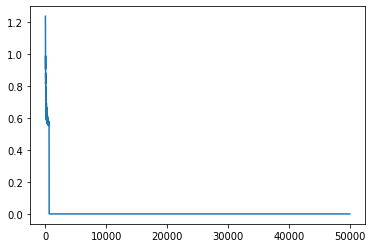

In [ ]:
plt.plot(trace['TrainLoss'])


In [ ]:
ValidationBitErrors.shape

torch.Size([500])

In [ ]:
ValidationLosses[599]

IndexError: ignored